# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [110]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
!pip install sidetable
import sidetable as stb
from tqdm.auto import tqdm

In [111]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [112]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [113]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [114]:
df_reviews.head(1)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335


Let's check for missing values.

In [115]:
df_reviews.stb.missing(style=True)

,missing,total,percent
average_rating,2,"47,331",0.00%
votes,2,"47,331",0.00%
tconst,0,"47,331",0.00%
ds_part,0,"47,331",0.00%
pos,0,"47,331",0.00%
sp,0,"47,331",0.00%
rating,0,"47,331",0.00%
review,0,"47,331",0.00%
genres,0,"47,331",0.00%
title_type,0,"47,331",0.00%


Great! No missing values.

In [116]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

We are only have interest to see the information about columns: review, pos and ds_part.
So, all the columns have correct datatype. 

Let's see if there are duplicated data.

In [117]:
df_reviews.duplicated().sum()

0

No duplicates here.

## EDA

Let's check the number of movies and reviews over years.

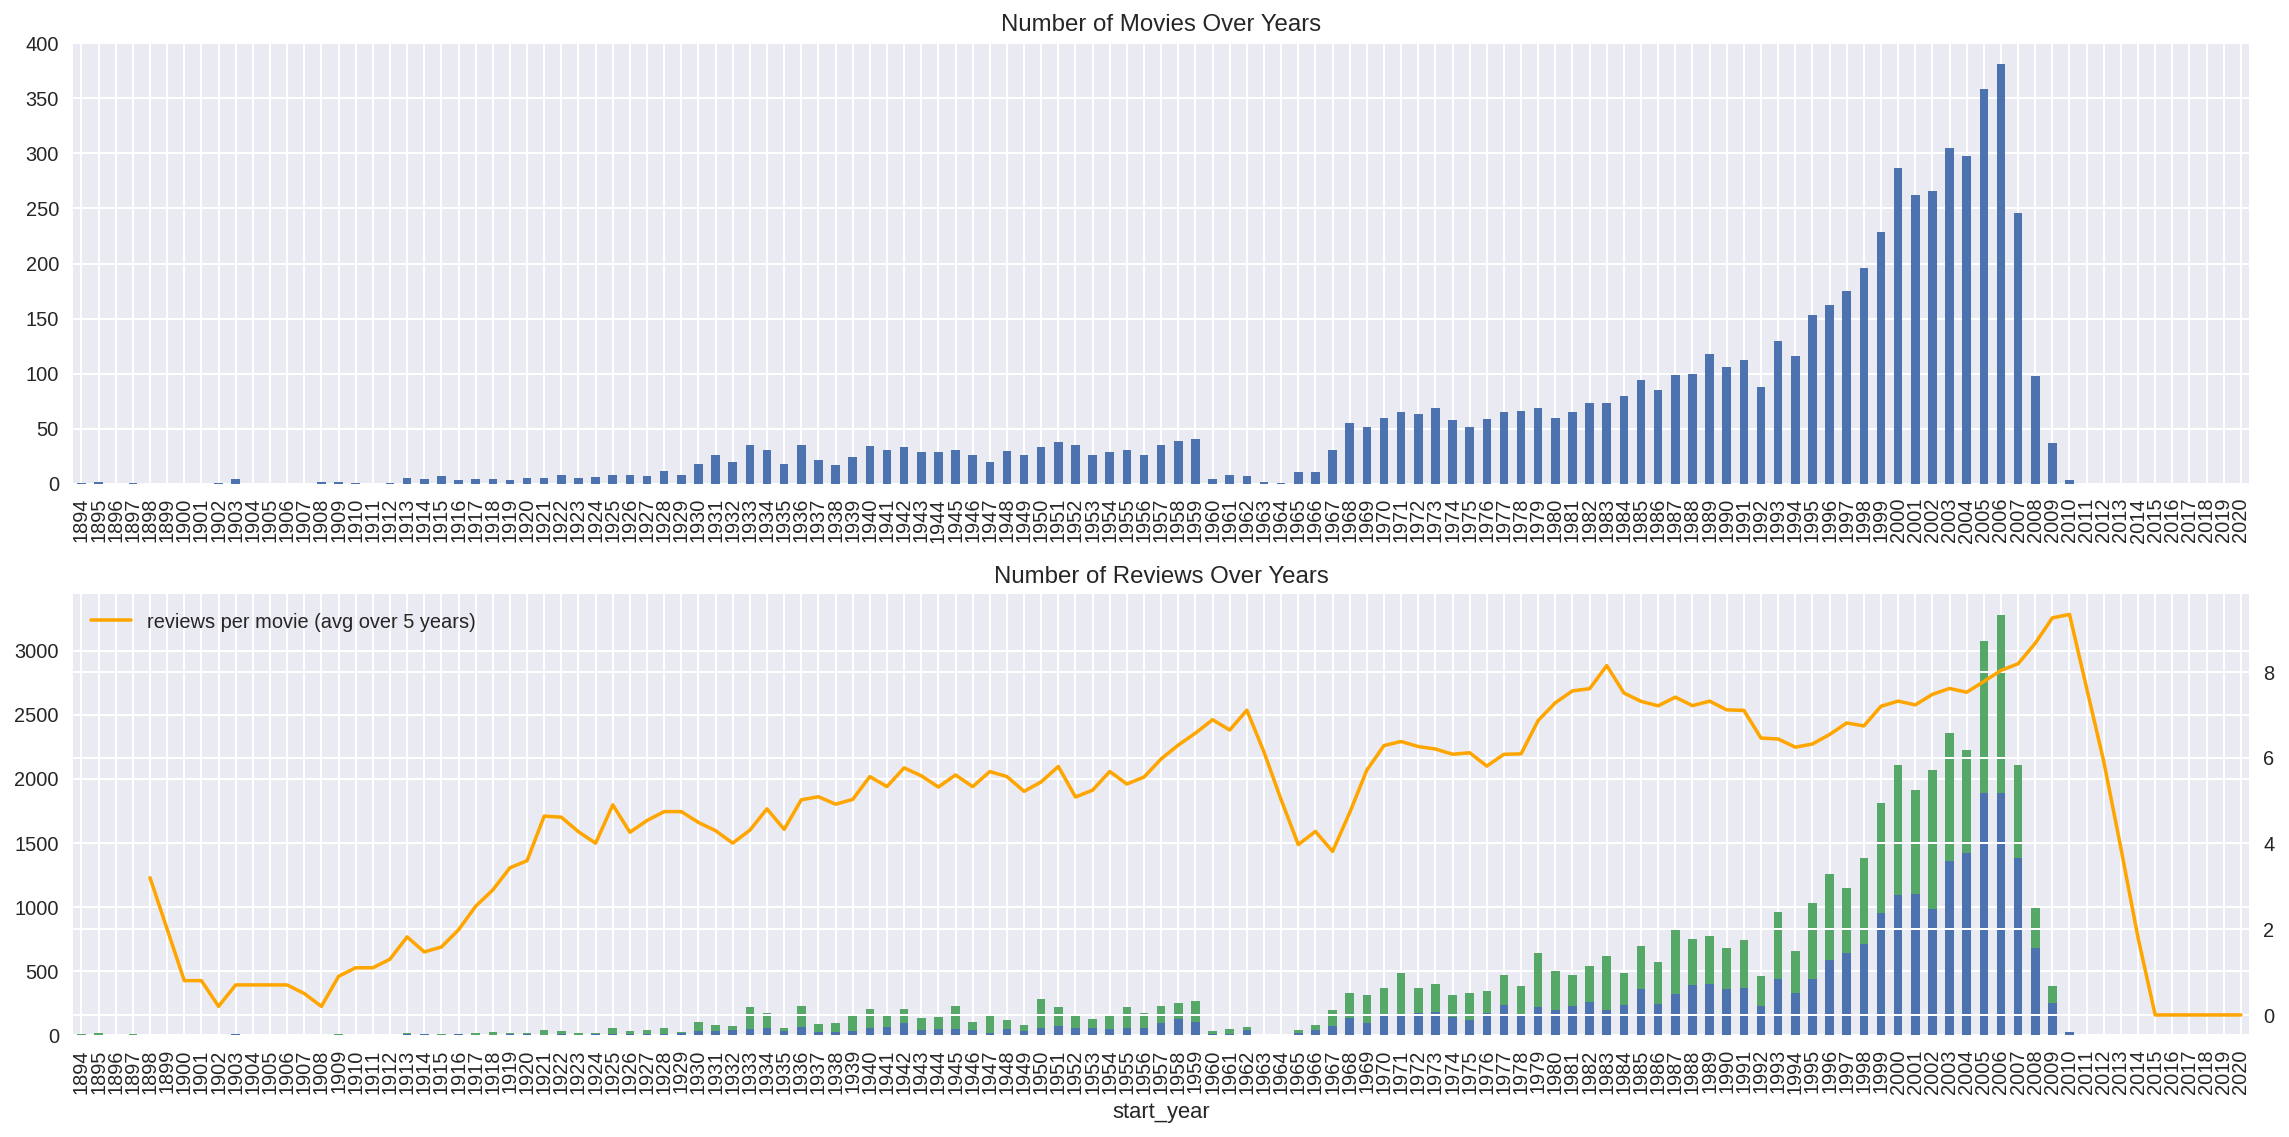

In [118]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We see mostly increase in number of movies created over the years.


Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

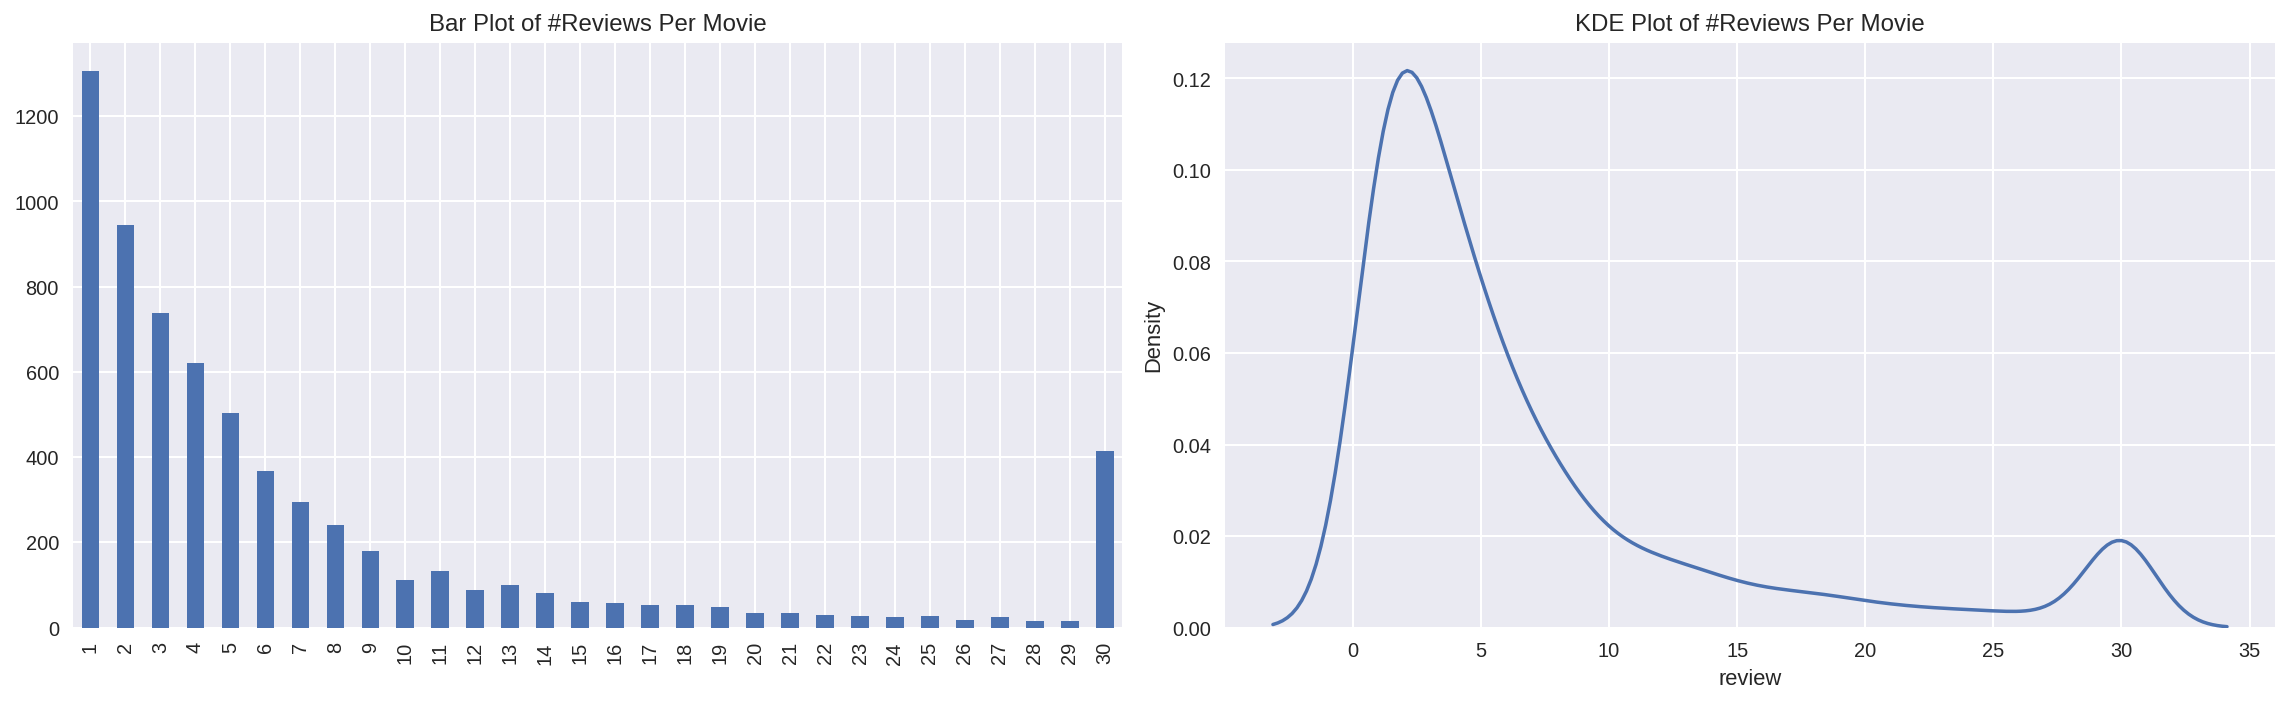

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Let's calculate mean and median.

In [120]:
dft.mean()

7.119584837545126

In [121]:
dft.median()

4.0

Most movies have  4 reviews. The mean value (7.11) is the average wich is like an outlier wich means that there are some few movies has more reviews than usual (like blockbusters).

In [122]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

The pos values (target) is equally distributed.

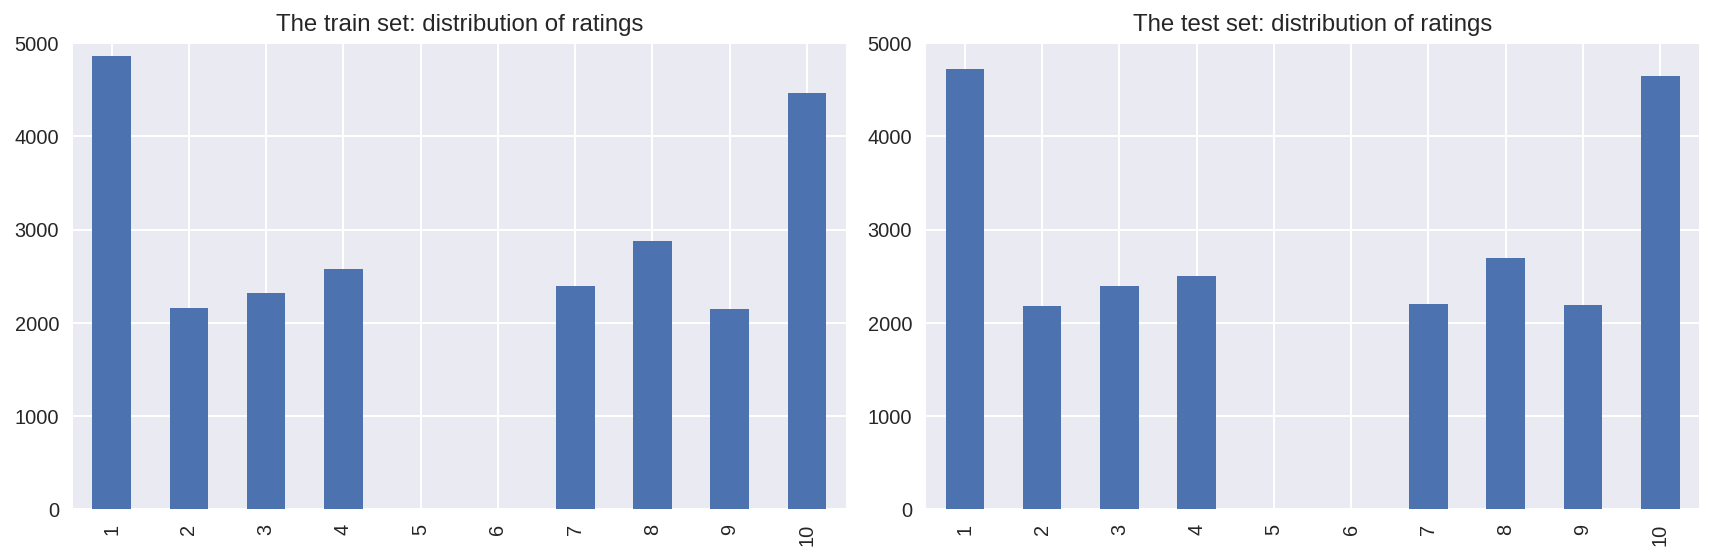

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution for train and test looks good.

Distribution of negative and positive reviews over the years for two parts of the dataset

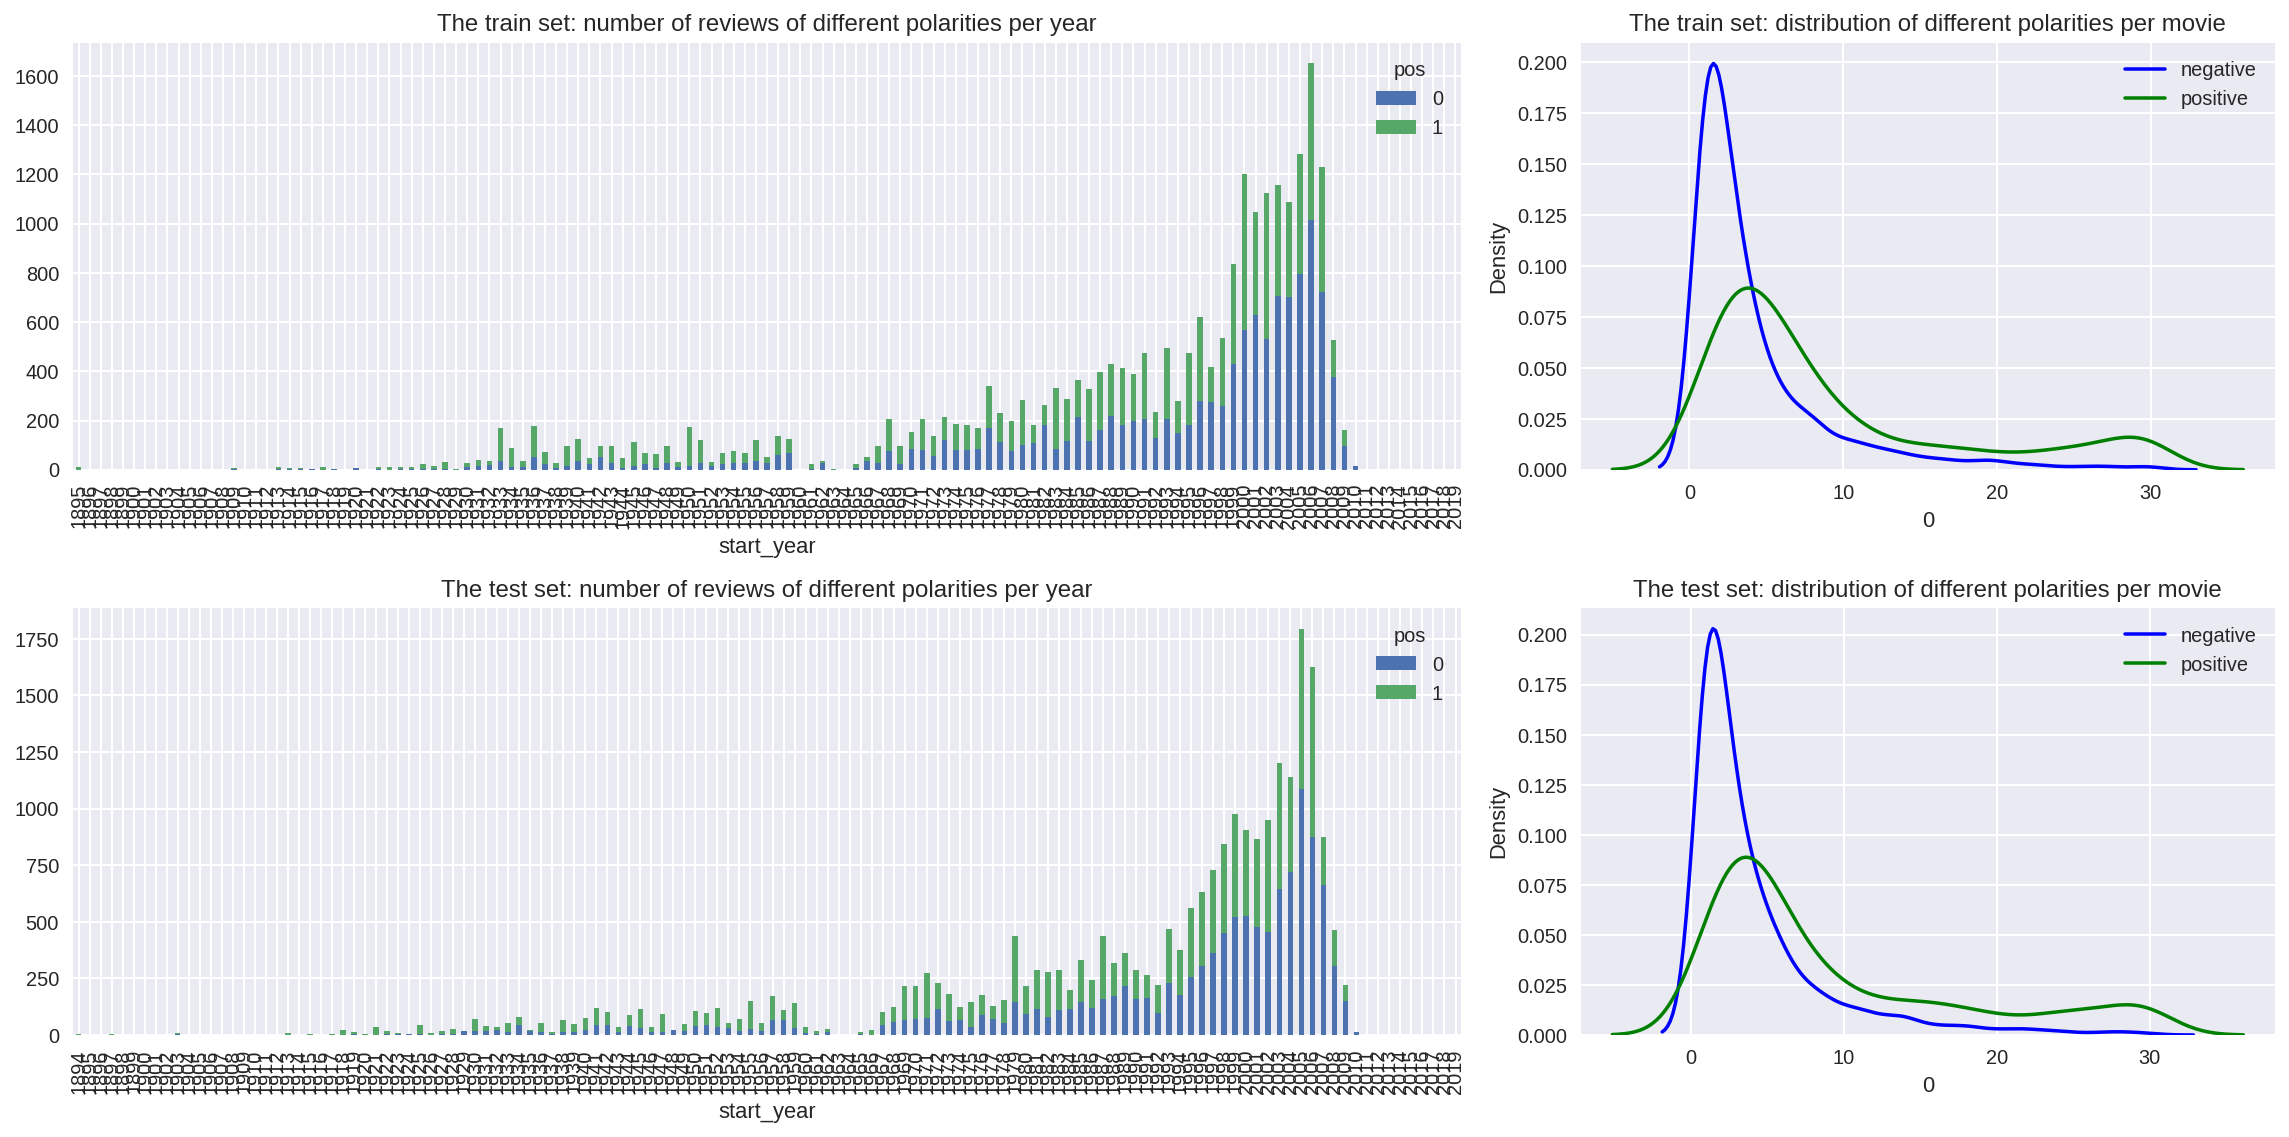

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

It seems that there are more negative reviews than positive.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [125]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

Function for clean text (texts in lowercase and without any digits, punctuations marks).

In [126]:
import string
import re

In [127]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans("","", string.punctuation))
    text = text.strip()
    return text

In [128]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: clean_text(x))

Let's see some reviews.

In [129]:
df_reviews['review_norm'][0]

'the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats not what i got out of it i didnt get anything in the first half theres a new character without introduction in every other scene the first halfhour is completely incomprehensible the rest is just one long annoying underlit chase scene theres always an irritating sound in the background whether its a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie'

In [130]:
df_reviews['review_norm'][3]

'um  a serious film about troubled teens in singapore a country i have not much knowledge on but have the previous wrong impression that all the kids there are highly disciplined and controlled by their family and government well i guess i am wrong just like other cities countries they also have their troubled teens who also lead the not so surprising rebellious way of life of drugs fights bad language and  many other obvious signs of being a bad boy the surprising part of this film isnt really about how these kids running around causing themselves and others trouble but rather the subtle gayness hidden behind their so call loyalty between them the bond between these brothers may very well originated from an unconscious gay tendency inside these boys though it isnt uncommon for str guys to have very close friendship with each other but watch this film closely it should be entering all sorts of gay film festivals and i would not be surprised that it may win itself a lot more awards towa

Seems clean.

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [131]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [132]:
from sklearn.dummy import DummyClassifier

In [133]:
dummy_train = []
dummy_test = []

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(df_reviews_train, train_target)

DummyClassifier(strategy='most_frequent')

Evaluating the model.

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


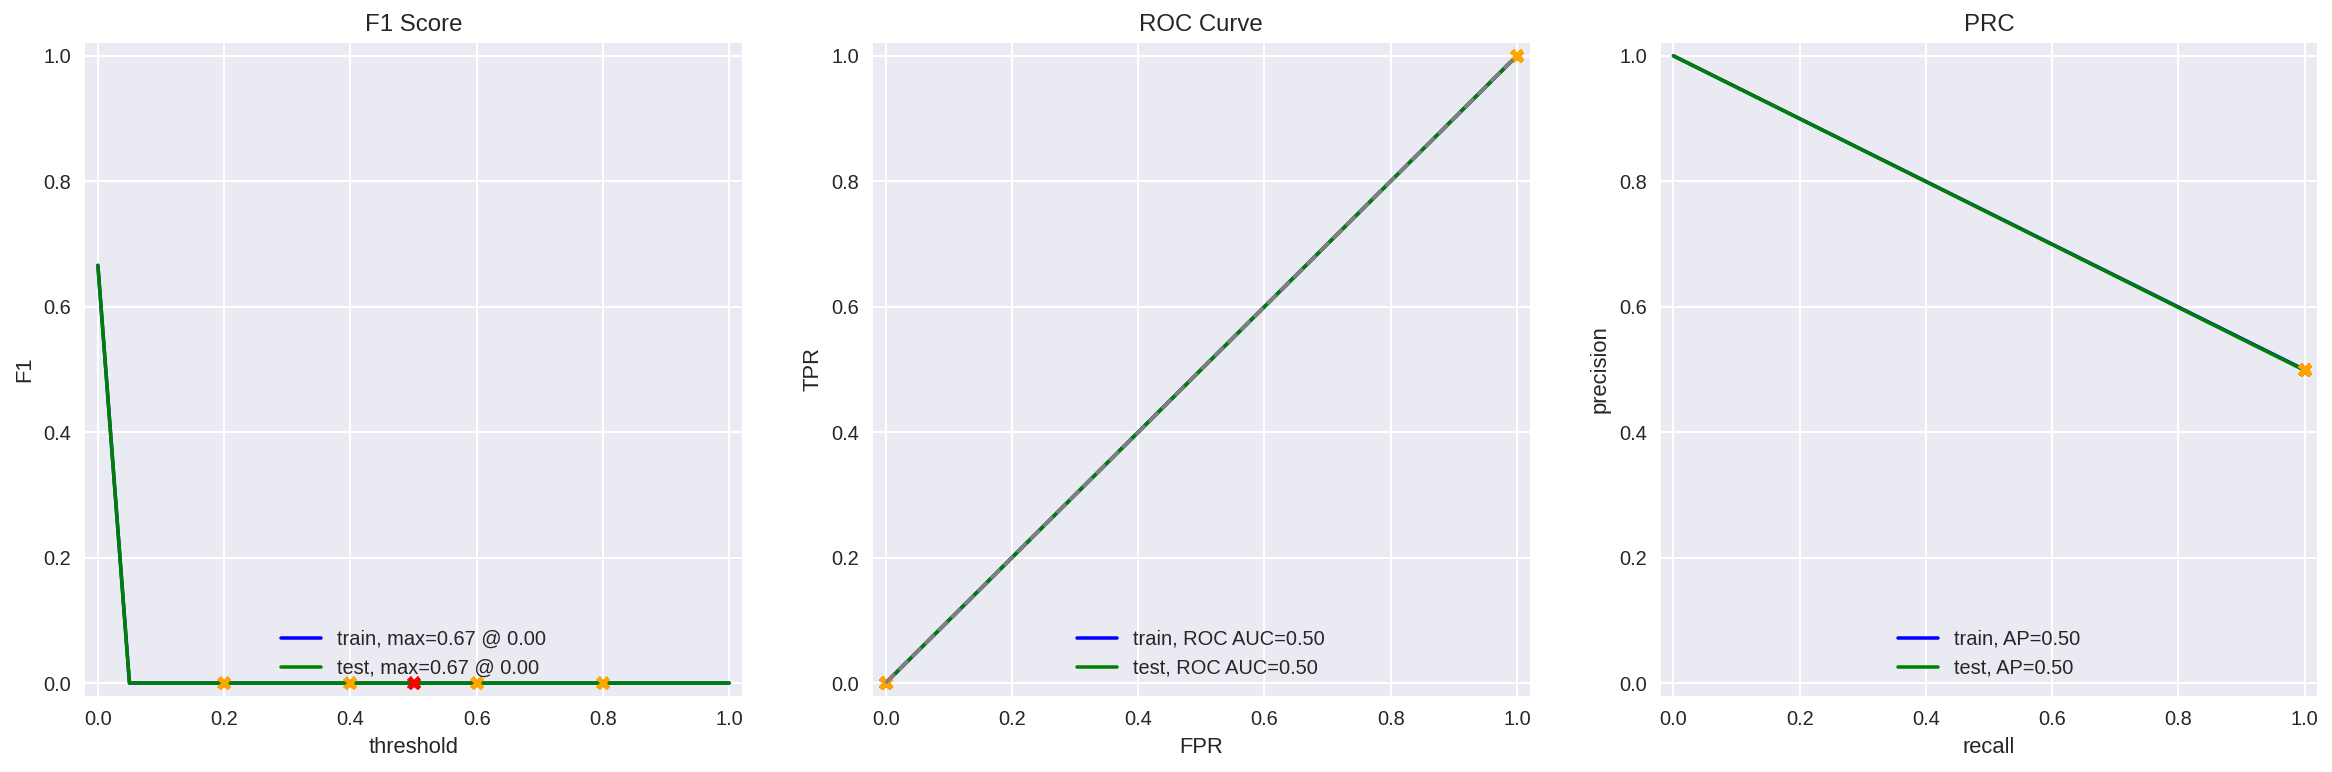

In [134]:
evaluate_model(dummy, df_reviews_train, train_target, df_reviews_test, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [135]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

from nltk import word_tokenize
!pip install stop-words
from stop_words import get_stop_words

First the data will be preprocessed with nltk lib and after that the data will be converted to vectors.

Tokenize train data.

In [136]:
df_reviews_train['review_norm_nltk']=df_reviews_train['review_norm'].apply(lambda X: word_tokenize(X))
df_reviews_train['review_norm_nltk'].head(3)

0    [the, pakage, implies, that, warren, beatty, a...
1    [how, the, hell, did, they, get, this, made, p...
7    [this, true, story, of, carlsons, raiders, is,...
Name: review_norm_nltk, dtype: object

Removing stop words.

In [137]:
stop_words=set(stopwords.words('english'))

In [138]:
df_reviews_train['review_norm_nltk'] = [word for word in df_reviews_train['review_norm_nltk'] if word not in get_stop_words('english')]
df_reviews_train['review_norm_nltk'].head(3)

0    [the, pakage, implies, that, warren, beatty, a...
1    [how, the, hell, did, they, get, this, made, p...
7    [this, true, story, of, carlsons, raiders, is,...
Name: review_norm_nltk, dtype: object

Lemmatize.

In [139]:
import nltk
from nltk.stem import WordNetLemmatizer 

In [140]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    x= [lemmatizer.lemmatize(w) for w in text]
    return ' '.join(x)

In [141]:
df_reviews_train['review_norm_nltk'] = df_reviews_train['review_norm_nltk'].apply(lemmatize_text)
df_reviews_train['review_norm_nltk'].head(2)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
Name: review_norm_nltk, dtype: object

Tokenize test data. 

In [142]:
df_reviews_test['review_norm_nltk']=df_reviews_test['review_norm'].apply(lambda X: word_tokenize(X))
df_reviews_test['review_norm_nltk'].head(3)

2    [there, is, no, real, story, the, film, seems,...
3    [um, a, serious, film, about, troubled, teens,...
4    [im, totally, agree, with, garryjohal, from, s...
Name: review_norm_nltk, dtype: object

Removing stop words.

In [143]:
df_reviews_test['review_norm_nltk'] = [word for word in df_reviews_test['review_norm_nltk'] if word not in get_stop_words('english')]
df_reviews_test['review_norm_nltk'].head(3)

2    [there, is, no, real, story, the, film, seems,...
3    [um, a, serious, film, about, troubled, teens,...
4    [im, totally, agree, with, garryjohal, from, s...
Name: review_norm_nltk, dtype: object

Lemmatize.(test)

In [144]:
df_reviews_test['review_norm_nltk'] = df_reviews_test['review_norm_nltk'].apply(lemmatize_text)
df_reviews_test['review_norm_nltk'].head(2)

2    there is no real story the film seems more lik...
3    um a serious film about troubled teen in singa...
Name: review_norm_nltk, dtype: object

Time to train and test the model.

In [145]:
count_tf_idf_train = TfidfVectorizer(stop_words=stop_words)

count_tf_idf_train = count_tf_idf_train.fit(df_reviews_train['review_norm_nltk'])
tf_idf_train = count_tf_idf_train.transform(df_reviews_train['review_norm_nltk'])

tf_idf_test = count_tf_idf_train.transform(df_reviews_test['review_norm_nltk'])

In [146]:
logreg = LogisticRegression(random_state = 12345, solver = 'liblinear')
logreg.fit(tf_idf_train, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

In [147]:
model_1=logreg

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


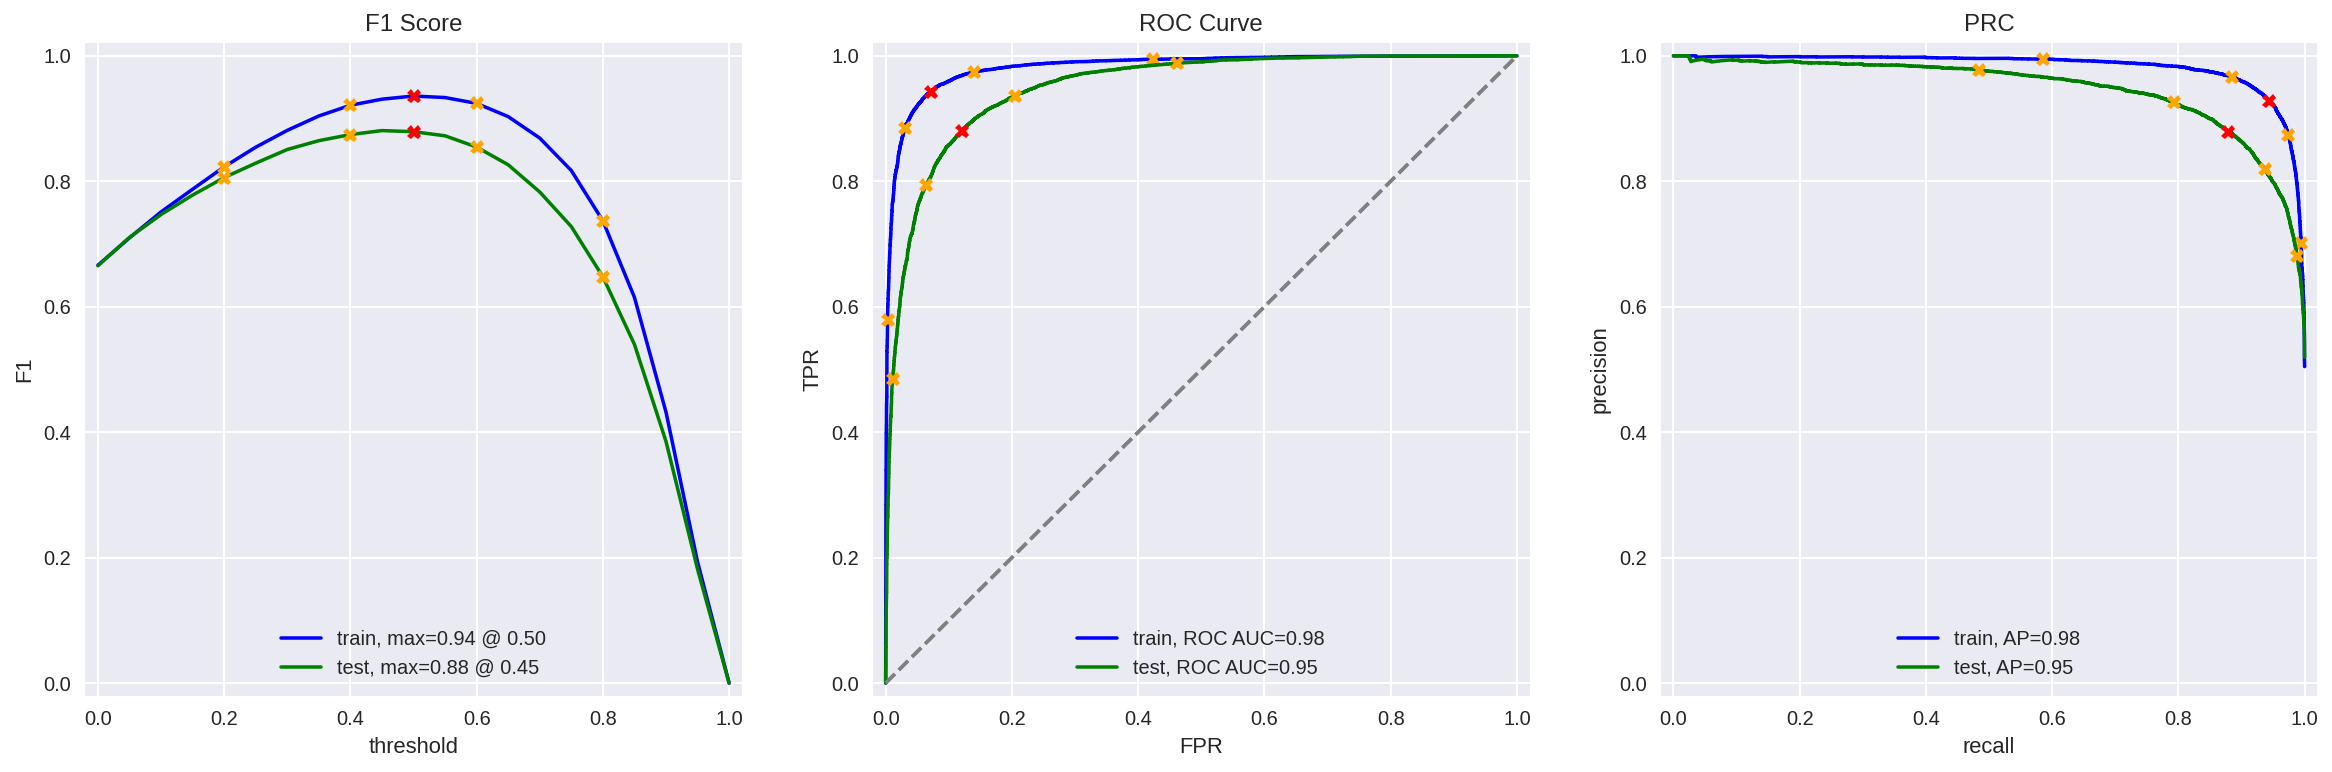

In [148]:
evaluate_model(model_1, tf_idf_train, train_target, tf_idf_test, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [149]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [150]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

Preprocessing train data.

In [151]:
df_reviews_train['review_norm_spacy']=df_reviews_train['review_norm'].apply(lambda X: text_preprocessing_3(X))
df_reviews_train['review_norm_spacy'].head(3)

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
7    this true story of carlson raider be more of a...
Name: review_norm_spacy, dtype: object

Preprocessing test data.

In [152]:
df_reviews_test['review_norm_spacy']=df_reviews_test['review_norm'].apply(lambda X: text_preprocessing_3(X))
df_reviews_test['review_norm_spacy'].head(3)

2    there be no real story the film seem more like...
3    um   a serious film about troubled teen in sin...
4    I m totally agree with garryjohal from singapo...
Name: review_norm_spacy, dtype: object

Time to train and test.

In [153]:
count_tf_idf_train_sy = TfidfVectorizer(stop_words=stop_words)

count_tf_idf_train_sy = count_tf_idf_train_sy.fit(df_reviews_train['review_norm_spacy'])
tf_idf_train_sy = count_tf_idf_train_sy.transform(df_reviews_train['review_norm_spacy'])

tf_idf_test_sy = count_tf_idf_train_sy.transform(df_reviews_test['review_norm_spacy'])

In [154]:
logreg_sy = LogisticRegression(random_state = 12345, solver = 'liblinear')
logreg_sy.fit(tf_idf_train_sy, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

In [155]:
model_2=logreg_sy

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


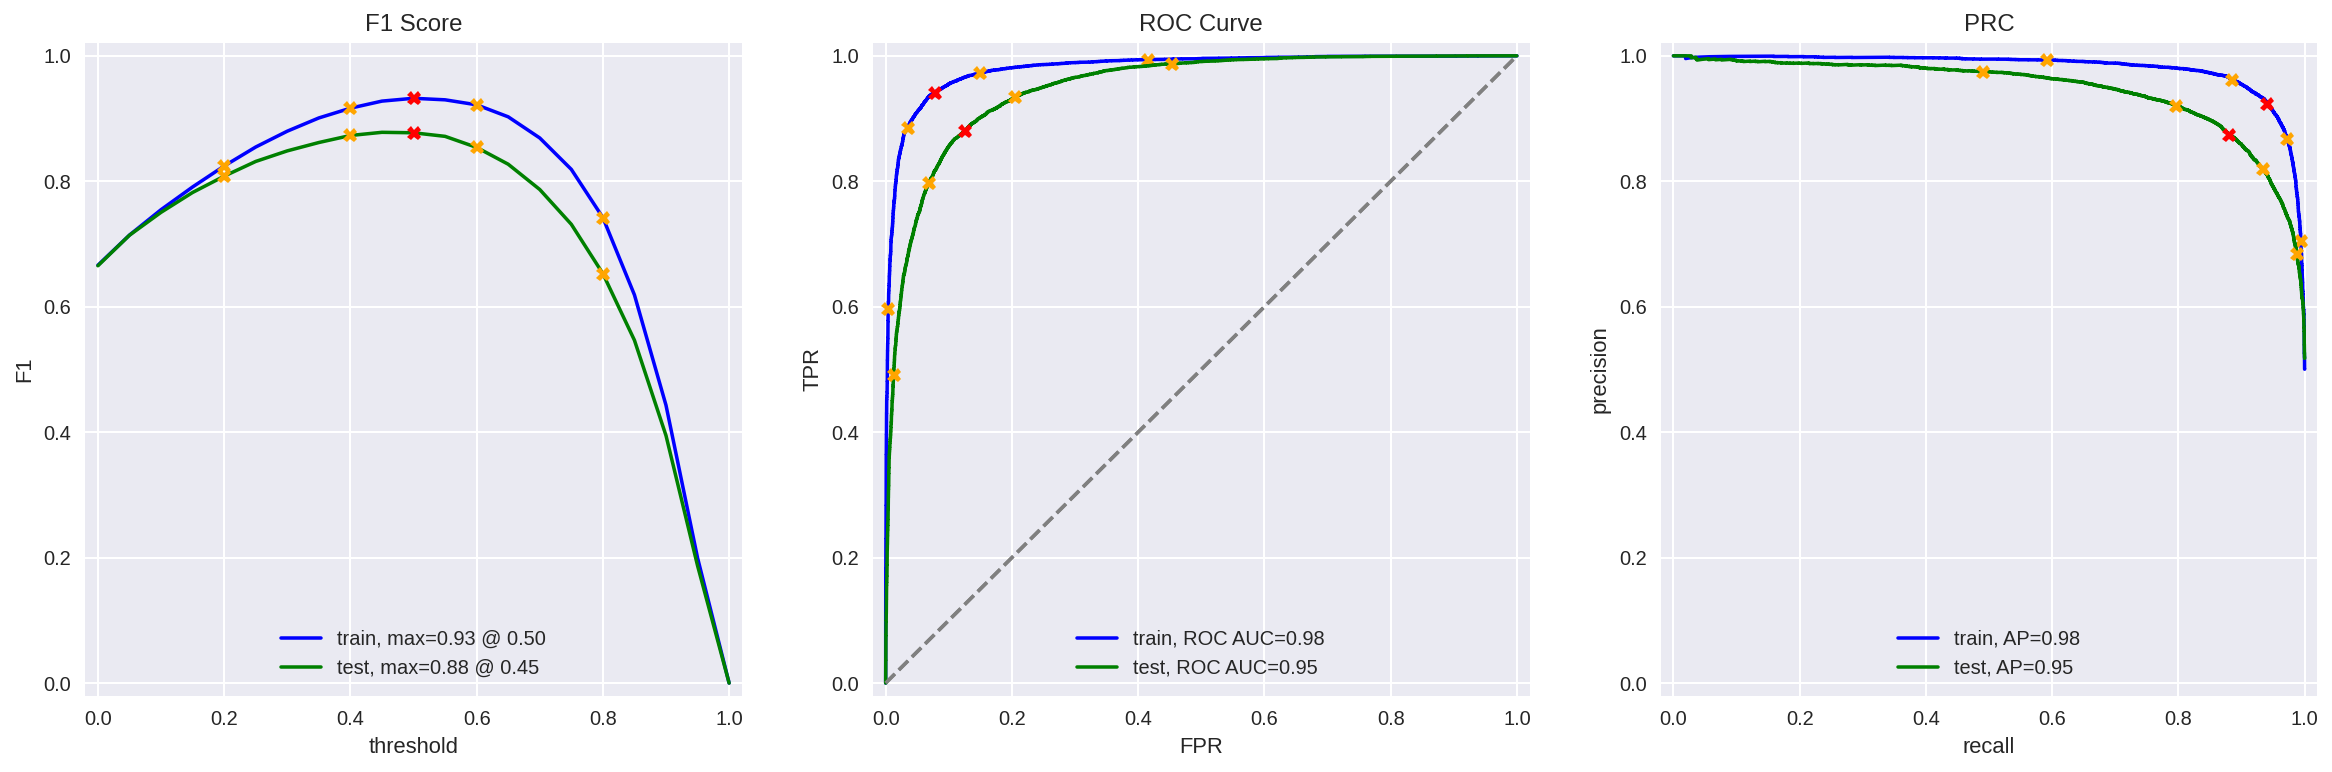

In [156]:
evaluate_model(model_2, tf_idf_train_sy, train_target, tf_idf_test_sy, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [157]:
import lightgbm as lgb

In [158]:
! pip install optuna
import optuna
import warnings
warnings.filterwarnings('ignore')

In [159]:
from sklearn.metrics import f1_score
#from OptunaCrossValidationSearch import OptunaCrossValidationSearch
#from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [160]:
def objective_lgbm(trial):
    max_depth = trial.suggest_int('max_depth', 4, 70)
    n_estimators = trial.suggest_int('n_estimators', 40, 250)
    learning_rate = trial.suggest_uniform('learning_rate',0.01, 1.5)
    min_split_gain = trial.suggest_int('min_split_gain', 2, 30)
    
    model = lgb.LGBMClassifier(max_depth=max_depth, n_estimators =n_estimators, learning_rate = learning_rate, 
    min_split_gain = min_split_gain,random_state = 12345)
    
    
    #model.fit(tf_idf_train_sy,train_target)
    #pred = model.predict(tf_idf_test_sy)
    #f1 = f1_score(test_target, pred)
    
    f1 = np.mean(cross_val_score(model, tf_idf_train_sy, train_target, scoring='f1',cv=3))
    
    return f1

In [161]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials = 100)
lgbm_best_params = study.best_params
print('F1 score ', study.best_value)
print('Best parameters: ', study.best_params)


F1 score  0.8579466505176709
Best parameters:  {'max_depth': 24, 'n_estimators': 202, 'learning_rate': 0.10146572893224325, 'min_split_gain': 2}
CPU times: user 2h 18min 55s, sys: 30.5 s, total: 2h 19min 25s
Wall time: 2h 19min 59s


In [ ]:
lgbm_best_model = lgb.LGBMClassifier(max_depth = lgbm_best_params['max_depth'], 
                                     n_estimators = lgbm_best_params['n_estimators'], 
                                     learning_rate = lgbm_best_params['learning_rate'],
                                     min_split_gain = lgbm_best_params['min_split_gain'],
                                     random_state = 12345)

lgbm_best_model.fit(tf_idf_train_sy, train_target)

          train  test
Accuracy   0.96  0.86
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


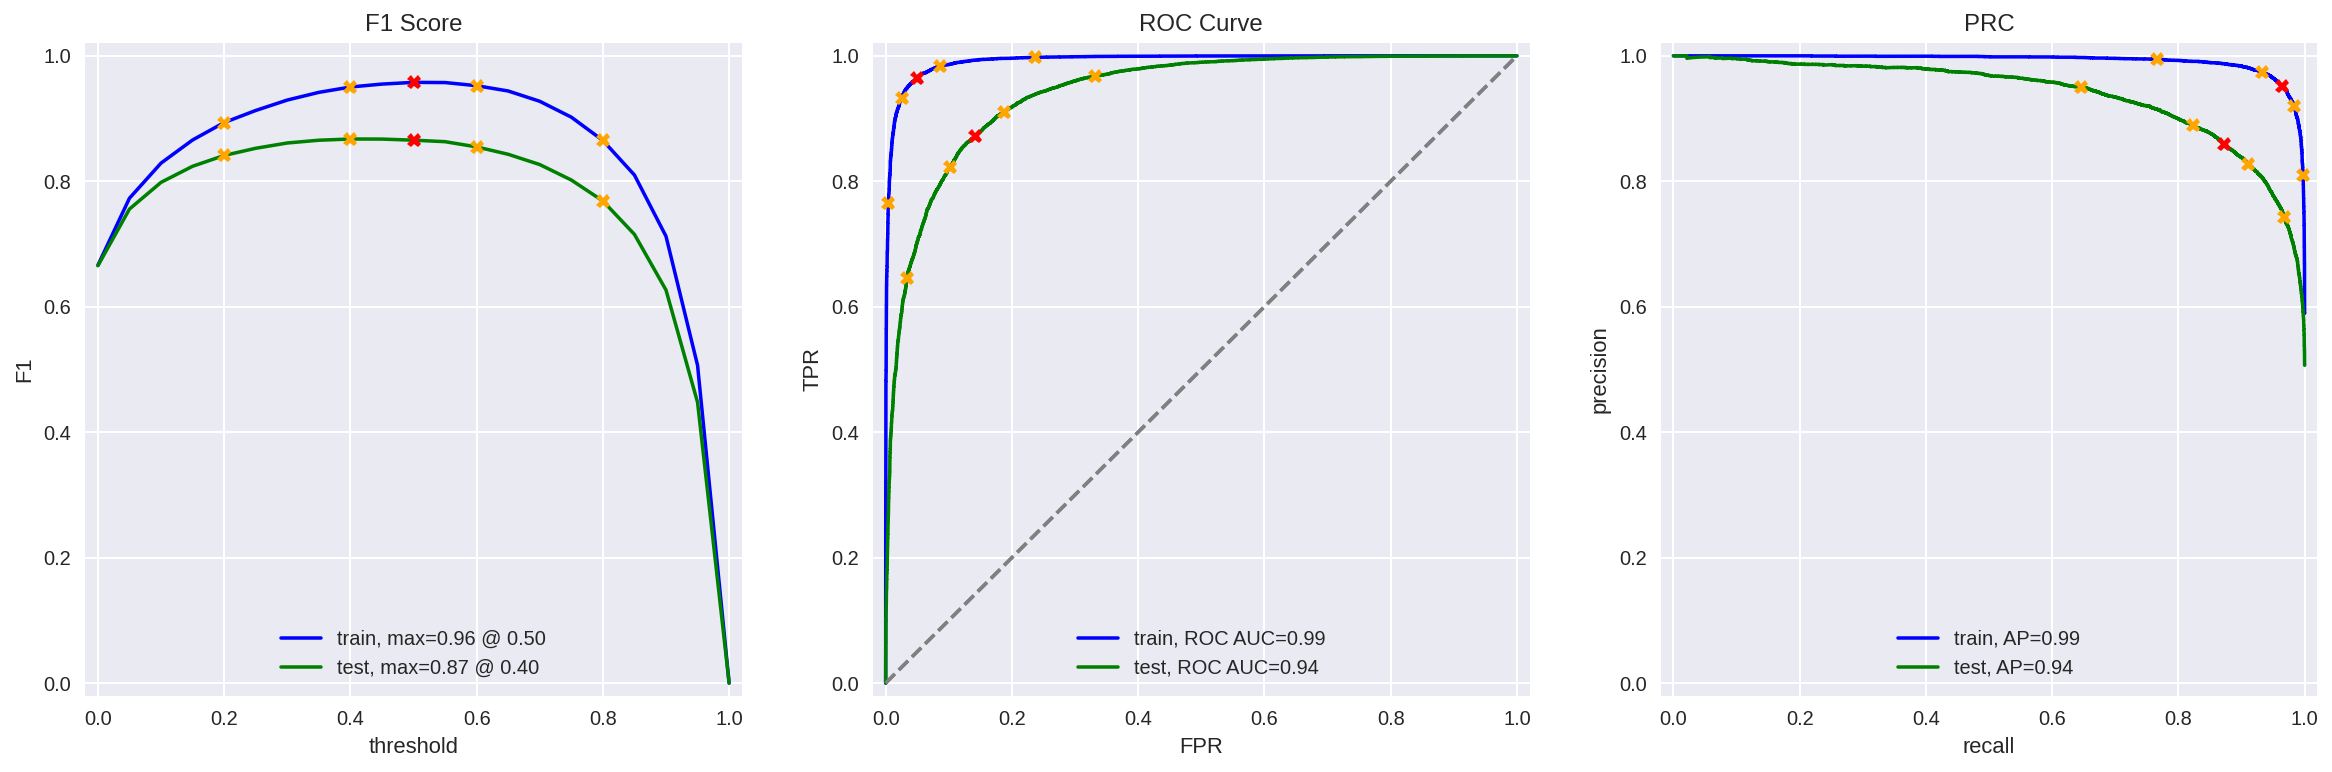

In [163]:
model_3=lgbm_best_model

evaluate_model(model_3, tf_idf_train_sy, train_target, tf_idf_test_sy, test_target)

## Model 4 - NLTK, TF-IDF and LGBMClassifier

In [164]:
def objective_lgbm_nltk(trial):
    
    
    max_depth = trial.suggest_int('max_depth', 4, 70)
    n_estimators = trial.suggest_int('n_estimators', 40, 250)
    learning_rate = trial.suggest_uniform('learning_rate',0.01, 1.5)
    min_split_gain = trial.suggest_int('min_split_gain', 2, 30)
    
    
    model = lgb.LGBMClassifier(max_depth=max_depth, n_estimators = n_estimators, 
                               learning_rate = learning_rate, min_split_gain = min_split_gain,
                               random_state = 12345)
    
    #model.fit(tf_idf_train, train_target)
    #pred = model.predict(tf_idf_test)
    #f1 = f1_score(test_target, pred)
    
    f1 = np.mean(cross_val_score(model, tf_idf_train, train_target, scoring='f1',cv=3))

    # output: evaluation score
    return f1

In [165]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm_nltk, n_trials = 50)
lgbm_best_params = study.best_params
print('F1 score ', study.best_value)
print('Best parameters: ', study.best_params)

F1 score  0.8553879338227679
Best parameters:  {'max_depth': 45, 'n_estimators': 106, 'learning_rate': 0.17756963788250796, 'min_split_gain': 4}
CPU times: user 46min 53s, sys: 15.1 s, total: 47min 8s
Wall time: 47min 19s


In [166]:
lgbm_best_model_nltk = lgb.LGBMClassifier(max_depth = lgbm_best_params['max_depth'], 
                                          n_estimators = lgbm_best_params['n_estimators'], 
                                          learning_rate = lgbm_best_params['learning_rate'],
                                          min_split_gain = lgbm_best_params['min_split_gain'],
                                          random_state = 12345)

lgbm_best_model_nltk.fit(tf_idf_train, train_target)

LGBMClassifier(learning_rate=0.17756963788250796, max_depth=45,
               min_split_gain=4, n_estimators=106, random_state=12345)

          train  test
Accuracy   0.95  0.87
F1         0.95  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


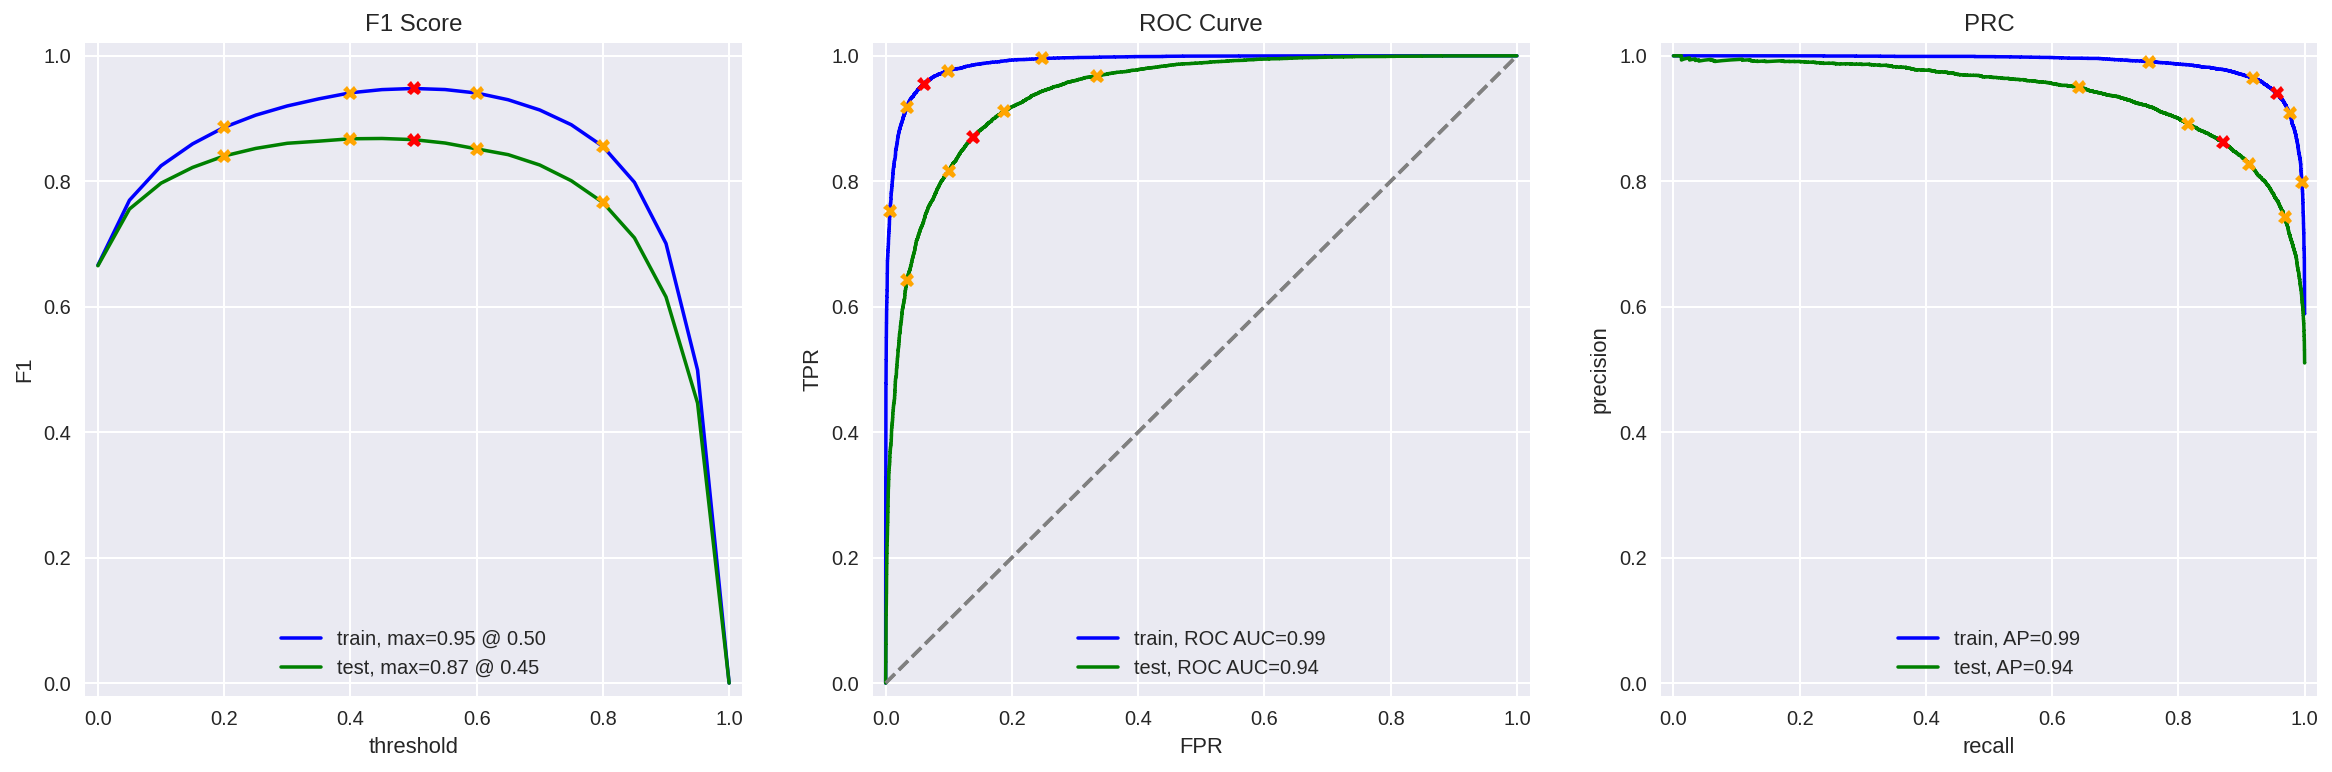

In [167]:
model_4=lgbm_best_model_nltk

evaluate_model(model_4, tf_idf_train, train_target, tf_idf_test, test_target)

## Moldel-5 spaCy, TF-IDF and Decision Tree Classifier.

In [168]:
from sklearn.tree import DecisionTreeClassifier

In [169]:
def objective_dec_tree(trial):
    max_depth = trial.suggest_int('max_depth', 1,8, tf_idf_train_sy.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40)
    min_impurity_decrease =trial.suggest_uniform('min_impurity_decrease', 0.01, 0.3)
    
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split = min_samples_split, 
    min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,random_state = 12345)
    
    #model.fit(tf_idf_train_sy, train_target)
    #pred = model.predict(tf_idf_test_sy)
    #f1 = f1_score(test_target, pred)
    
    f1 = np.mean(cross_val_score(model, tf_idf_train_sy, train_target, scoring='f1',cv=3))

    return f1

In [170]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_dec_tree, n_trials = 100)
tree_best_params = study.best_params
print('F1 score: ', study.best_value)
print('Best Parameters: ', study.best_params)


F1 score:  0.7228572292418364
Best Parameters:  {'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 27, 'min_impurity_decrease': 0.05501456884667296}
CPU times: user 3min 27s, sys: 312 ms, total: 3min 27s
Wall time: 3min 27s


In [171]:
dec_tree_best_model = DecisionTreeClassifier(max_depth =tree_best_params['max_depth'], 
                      min_impurity_decrease =tree_best_params['min_impurity_decrease'], 
                      min_samples_split =tree_best_params['min_samples_split'],
                      min_samples_leaf =tree_best_params['min_samples_leaf'],random_state = 12345)

dec_tree_best_model.fit(tf_idf_train_sy,train_target)


DecisionTreeClassifier(max_depth=1, min_impurity_decrease=0.05501456884667296,
                       min_samples_leaf=27, min_samples_split=9,
                       random_state=12345)

          train  test
Accuracy   0.66  0.66
F1         0.72  0.72
APS        0.59  0.60
ROC AUC    0.66  0.66


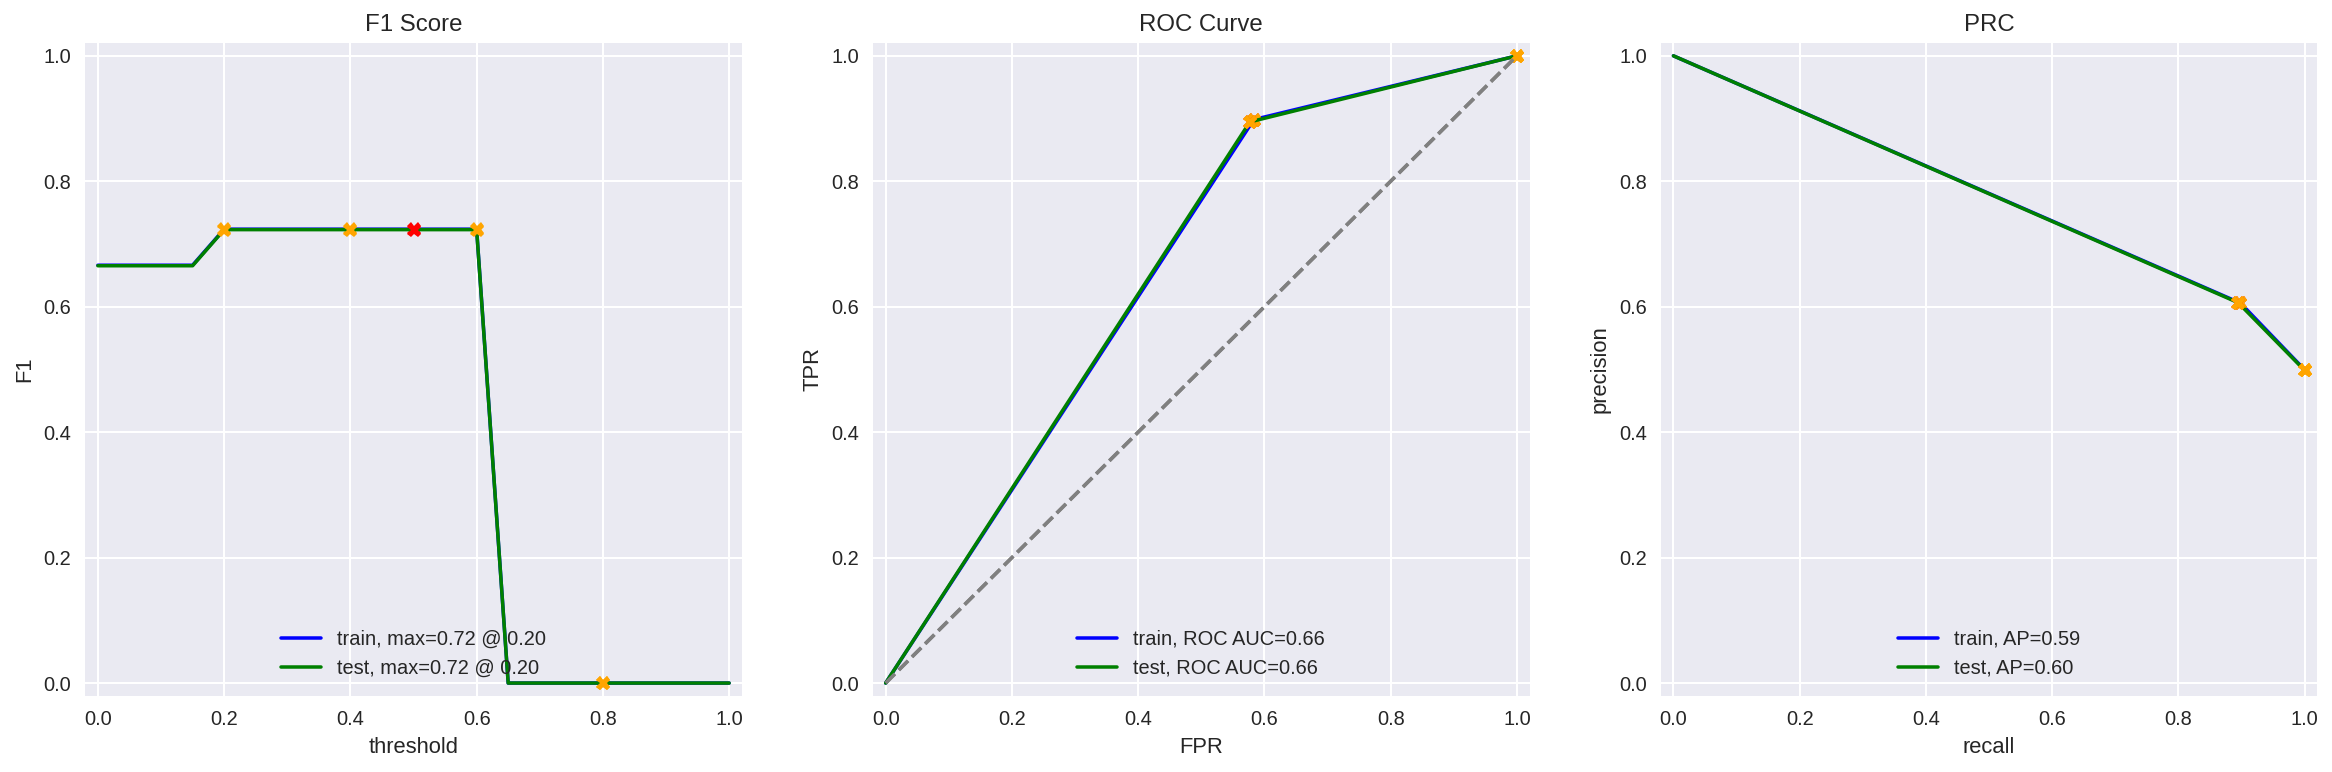

In [172]:
model_5 = dec_tree_best_model

evaluate_model(model_5, tf_idf_train_sy, train_target, tf_idf_test_sy, test_target)

## Model 6 NLTK, TF-IDF and Decision Tree Classifier.

In [173]:
def objective_dec_tree_nltk(trial):
    max_depth = trial.suggest_int('max_depth', 1,8, tf_idf_train.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40)
    min_impurity_decrease =trial.suggest_uniform('min_impurity_decrease', 0.01, 0.3)
    
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split = min_samples_split, 
    min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,random_state = 12345)
    
    #model.fit(tf_idf_train, train_target)
    #pred = model.predict(tf_idf_test)
    #f1 = f1_score(test_target, pred)
    
    f1 = np.mean(cross_val_score(model, tf_idf_train, train_target, scoring='f1',cv=3))

    return f1

In [174]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_dec_tree_nltk, n_trials = 100)
tree_best_params = study.best_params
print('F1 score: ', study.best_value)
print('Best Parameters: ', study.best_params)

F1 score:  0.6988448598546015
Best Parameters:  {'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 28, 'min_impurity_decrease': 0.03186949716543917}
CPU times: user 3min 38s, sys: 236 ms, total: 3min 38s
Wall time: 3min 38s


In [175]:
dec_tree_best_model_nltk = DecisionTreeClassifier(max_depth =tree_best_params['max_depth'], 
                                                   min_impurity_decrease =tree_best_params['min_impurity_decrease'], 
                                                   min_samples_split =tree_best_params['min_samples_split'],
                                                   min_samples_leaf =tree_best_params['min_samples_leaf'],random_state = 12345)

dec_tree_best_model_nltk.fit(tf_idf_train,train_target)

DecisionTreeClassifier(max_depth=1, min_impurity_decrease=0.03186949716543917,
                       min_samples_leaf=28, min_samples_split=10,
                       random_state=12345)

          train  test
Accuracy   0.61  0.61
F1         0.70  0.70
APS        0.57  0.56
ROC AUC    0.61  0.62


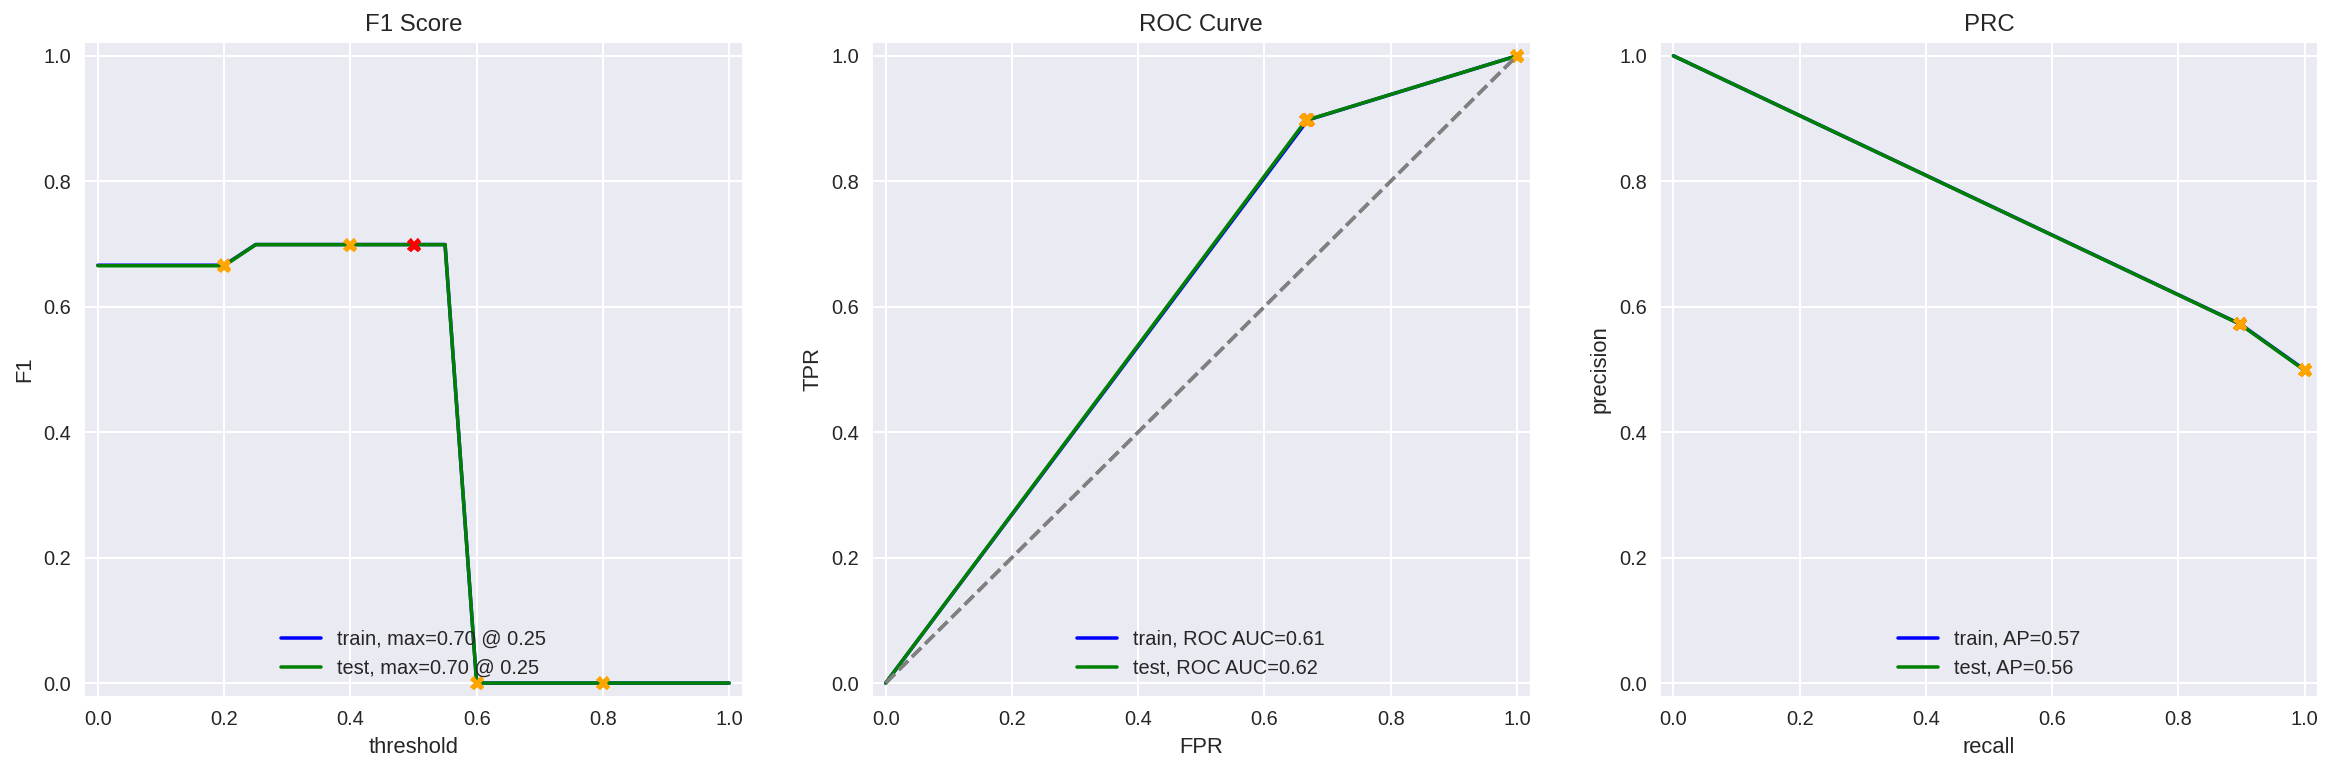

In [176]:
model_6 = dec_tree_best_model_nltk

evaluate_model(model_6, tf_idf_train, train_target, tf_idf_test, test_target)

The results.

NLTK, TF-IDF and LR F1 score: Train - 0.94  Test - 0.88  

spaCy, TF-IDF and LR F1 score: Train - 0.93  Test - 0.88


spaCy, TF-IDF and LGBMClassifier: Train - 0.96  Test - 0.87 

NLTK, TF-IDF and LGBMClassifier: Train - 0.98  Test - 0.87  


spaCy, TF-IDF and Decision Tree Classifier: Train - 0.72  Test - 0.72

NLTK, TF-IDF and Decision Tree Classifier: Train - 0.70  Test - 0.70



     ###  the best results for predictions made by LR model.  ###

###  Model 9 - BERT

In [177]:
import torch
import transformers

In [178]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [179]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [180]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: clean_text(x)) # <put here the same normalization logic as for the main dataset>

my_reviews

### Model 1 NLTK, TF-IDF and LR.

In [ ]:
texts = my_reviews['review_norm']
texts=texts.apply(lambda x: clean_text(x))

In [ ]:
#tokinize
texts['review_norm_nltk']=my_reviews['review_norm'].apply(lambda X: word_tokenize(X))
texts['review_norm_nltk'] = texts['review_norm_nltk'].reset_index(drop = True)
texts['review_norm_nltk'].head(3)

In [ ]:
texts['review_norm_nltk'] = texts['review_norm_nltk'].apply(lemmatize_text)

texts['review_norm_nltk'].head(2)


In [ ]:




tfidf_vectorizer_2=count_tf_idf_train.transform(texts['review_norm_nltk'])


my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_2)[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 2 spacy , TF-IDF and LR.

In [ ]:
tfidf_vectorizer_3=count_tf_idf_train_sy.transform(texts['review_norm_nltk'])



my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

From results we see that LR is the best one for predictions and for (my reviews) data set it seems like spacy predictions are a little better then nltk.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions